En este notebook se realizará la implementación de un modelo de regresión lineal o multiple para predecir el rendimiento de un cultivo con base a diferentes
varaibles predictoras.

In [1]:
# Importar librerias

In [106]:
import pandas as pd
import geopandas as gpd
import os
from pathlib import PurePath
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

## Cargar datos

In [4]:
vis_22 = r"C:\Users\Isai\Documents\Tesis\code\data_analysis\all_vars\zafra2022"
gdf = gpd.read_file(r"C:\Users\Isai\Documents\Tesis\code\Parcelas\poligonos_parcelas.geojson")

In [124]:
vis_df = pd.DataFrame(columns=[
    'parcela',
    'vis_value',
    'precip',
    'etc', 
    'dias'
])

In [125]:
for i in os.listdir(vis_22):
    if i.endswith('.csv'):
        df = pd.read_csv(PurePath(vis_22, i))
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        parcela_id = int(i.split('_')[1].split('.')[0])
        id_max_value = df['ndvi'].idxmax()
        date_max_value = df.loc[id_max_value, 'Fecha']
        print(parcela_id, date_max_value)
        vis_value = df.loc[id_max_value, 'ndvi']
        lluvia = df.loc[id_max_value, 'precip_acum']
        etc_acum = df.loc[id_max_value, 'etc_acum']
        days = (date_max_value - df['Fecha'].min()).days
        
        
        vis_df = vis_df._append({
            'parcela': parcela_id,
            'vis_value': vis_value,
            'precip': lluvia,
            'etc': etc_acum,
            'dias': days
        }, ignore_index=True)

1 2022-10-25 00:00:00
10 2022-10-13 00:00:00
11 2022-09-30 00:00:00
13 2022-11-13 00:00:00
14 2022-11-19 00:00:00
15 2022-11-25 00:00:00
16 2022-11-16 00:00:00
2 2022-11-22 00:00:00
3 2022-10-11 00:00:00
4 2022-11-28 00:00:00
5 2022-11-06 00:00:00
6 2022-12-08 00:00:00
7 2022-09-29 00:00:00
8 2022-12-05 00:00:00
9 2022-12-07 00:00:00


C:\Users\Isai\AppData\Local\Temp\ipykernel_3956\1495001679.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vis_df = vis_df._append({


In [23]:
merged_df = pd.merge(gdf, vis_df, left_on='Id', right_on='parcela', how='inner')

In [25]:
merged_df.drop(columns=['Productor', 'Ciclo', 'Riego', 'Variedad', 'Siembra', 'Cosecha', 'geometry'], inplace=True)

In [26]:
merged_df.corr(method='pearson')

,Id,Rendimiento,parcela,vis_value,precip,etc,dias
Id,1.000000,-0.244834,1.000000,-0.213486,0.179818,-0.086144,0.097254
Rendimiento,-0.244834,1.000000,-0.244834,0.895832,-0.530568,0.150955,-0.060357
parcela,1.000000,-0.244834,1.000000,-0.213486,0.179818,-0.086144,0.097254
vis_value,-0.213486,0.895832,-0.213486,1.000000,-0.433723,0.231282,0.014450
precip,0.179818,-0.530568,0.179818,-0.433723,1.000000,-0.235985,0.206619
etc,-0.086144,0.150955,-0.086144,0.231282,-0.235985,1.000000,0.871624
dias,0.097254,-0.060357,0.097254,0.014450,0.206619,0.871624,1.000000


## Modelo de regresión lineal

In [146]:
X = merged_df['vis_value']
y = merged_df['Rendimiento']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
X_train = sm.add_constant(X_train)

In [149]:
model = sm.OLS(y_train, X_train).fit()

In [150]:
model.summary()

C:\Users\Isai\Documents\Tesis\code\.venv\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Rendimiento   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     45.26
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           5.18e-05
Time:                        22:00:09   Log-Likelihood:                -39.832
No. Observations:                  12   AIC:                             83.66
Df Residuals:                      10   BIC:                             84.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -131.3543     28.768     -4.566      0.001    -195.453     -67.256
vis_value    259.9565     38.639      6.728      0.000     173.864     346.049
==============================================================================
Omnibus:                        3.048   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                1.834
Skew:                          -0.943   Prob(JB):                        0.400
Kurtosis:                       2.662   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

In [152]:
print(model.mse_total)

269.69696969696963


In [153]:
mean_squared_error(model.predict(sm.add_constant(X)), y)

56.25643141484825

In [154]:
mse(y, model.predict(sm.add_constant(X)))

56.25643141484825

In [155]:
rmse(y, model.predict(sm.add_constant(X)))

7.500428748734851

In [156]:
data = pd.DataFrame({
    'y': y,
    'y_pred': model.predict(sm.add_constant(X))
})

In [157]:
data

,y,y_pred
0,48,36.455172
1,60,70.328160
2,45,44.426993
3,50,64.478570
4,75,69.478924
5,75,68.432860
6,75,74.519684
7,75,68.096597
8,75,69.129089
9,75,69.807213


In [158]:
merged_df['pred'] = model.predict(sm.add_constant(X))

In [159]:
merged_df

,Id,Rendimiento,parcela,vis_value,precip,etc,dias,pred
0,1,48,1.0,0.645529,582.23,826.524579,222.0,36.455172
1,2,60,2.0,0.775832,564.31,830.085568,205.0,70.328160
2,3,45,3.0,0.676195,547.55,948.437513,223.0,44.426993
3,4,50,4.0,0.753330,613.87,969.000817,256.0,64.478570
4,5,75,5.0,0.772565,588.12,921.097184,229.0,69.478924
5,6,75,6.0,0.768541,573.43,729.633043,206.0,68.432860
6,7,75,7.0,0.791956,547.35,1016.987247,241.0,74.519684
7,8,75,8.0,0.767247,571.98,696.859270,198.0,68.096597
8,9,75,9.0,0.771219,572.84,693.788541,200.0,69.129089
9,10,75,10.0,0.773828,558.62,1058.780065,255.0,69.807213


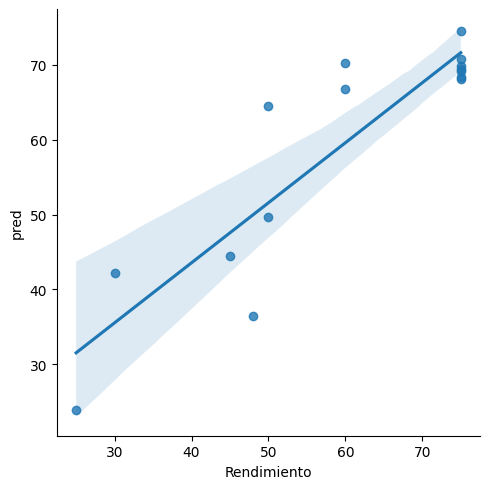

In [160]:
sns.lmplot(x='Rendimiento', y='pred', data=merged_df)